# Libraries

Import your libraries
https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57

In [1]:
import torch
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import rc
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

using gpu 4


# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [2]:
#load in df
Player = 15
Game = 2
Quarter = 2

df = pd.read_csv('matrix_Player_15_game_2_QuarterSplit_V2.csv') #Raw data with overlap

chunks = [df[i:i+100] for i in range(0,df.shape[0],50)]

df = pd.concat(chunks)

df['wheelRotationalSpeedX_Diff'] = np.insert(np.diff(df.wheelRotationalSpeedX,n=1),0,0)

#Clean and expand dataset
df = df.drop(columns = ['Unnamed: 0'])

# Split Data

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

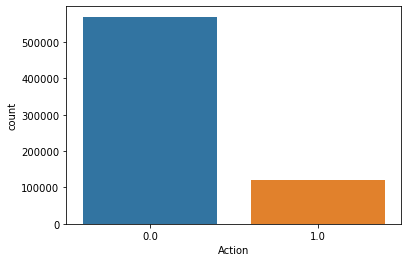

In [3]:
train = df[df.Quarter != Quarter]
val = df[df.Quarter == Quarter]

sns.countplot(train.Action)

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

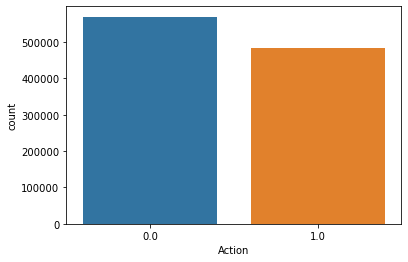

In [4]:
for i in range(0,2):
    train_correct = (train[train.Action == 1])
    train = pd.concat([train, train_correct], ignore_index=True)

sns.countplot(train.Action)

In [5]:
def rounddown(x):
    return (int(math.ceil(x / 100.0)) * 100) - 100

In [6]:
features = ['wheelRotationalSpeedX','frameRotationalSpeedY','frAcc','wheelRotationalSpeedX_Diff']

X_train = train[features]
X_train = X_train.iloc[0:rounddown(len(X_train))]

y_train = train[['Action']]
y_train = y_train.iloc[0:rounddown(len(y_train))]

X_val = val[features]
X_val = X_val.iloc[0:rounddown(len(X_val))]

y_val = val[['Action']]
y_val = y_val.iloc[0:rounddown(len(y_val))]

In [7]:
y_train = np.array_split(y_train, int(len(y_train)/100))
y_train = np.asarray(y_train)

y = []
for i in range (0,len(y_train)):
    y.append(y_train[i].max())
y_train = np.asarray(y)
y_train = pd.DataFrame(y_train)


y_val = np.array_split(y_val, int(len(y_val)/100))
y_val = np.asarray(y_val)

y = []
for i in range (0,len(y_val)):
    y.append(y_val[i].max())
y_val = np.asarray(y)
y_val = pd.DataFrame(y_val)

# Convert the X_train, X_val, y_train, y_val to Tensors

In [8]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
X_train = X_train.transpose(2,1)
X_train = torch.reshape(X_train, [-1,100,len(features)])

y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_val = torch.from_numpy(X_val.to_numpy()).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2,0)
X_val = X_val.transpose(2,1)
X_val = torch.reshape(X_val, [-1,100,len(features)])

y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

# Load Data into Dataloader

In [9]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64, num_workers = 4, pin_memory = True)

# RNN def
Define the Convolutional Neural Network

In [10]:
class LSTM(nn.Module):
    def __init__(self, hidden_state_size = 250, input_feature_size = len(features)):
        super().__init__()
        self.hidden_state_size = hidden_state_size
        self.feature_size = input_feature_size
        self.lstm1 = nn.LSTM(input_feature_size, self.hidden_state_size, batch_first=True)
        self.l2 = nn.Linear(self.hidden_state_size, 1)
    
    def forward(self, x):
        h, _ = self.lstm1(x)
        h = h[:,-1,:]
        y = self.l2(h)
        
        y = y + x[:,-1,-1:]
        
        return torch.sigmoid(y)
    
    def post_forward(self, y): 
        return torch.round(y)
    
RNN = LSTM()

# Training options

In [11]:
criterion = nn.BCELoss()

optimizer = optim.Adam(RNN.parameters(), lr=0.001)

# Training the RNN on the GPU


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_val = X_val.to(device)
y_val = y_val.to(device)

RNN = RNN.to(device)
criterion = criterion.to(device)

# Define functions for calculating Accuracy of model

In [13]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

# For loop through different epochs

In [14]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results_acc = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val'])
Results_loss = pd.DataFrame(columns = ['Epoch', 'Loss_train', 'Loss_val'])
Results_recall = pd.DataFrame(columns = ['Epoch', 'Recall_val'])
Results_prec = pd.DataFrame(columns = ['Epoch', 'Prec_val'])

for epoch in range(200):
    
    y_acc = torch.empty((64),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((64), device = 'cuda')
    
    for x, y in train_dl:

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = RNN(x)
        y_pred = y_pred.squeeze(axis = 1)
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
        
    if epoch % 1 == 0:

        train_acc = calculate_accuracy(y_acc, RNN.post_forward(y_pred_acc))
        train_loss = criterion(y_pred,y)
    
        y_val_pred = RNN(X_val)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val)
        val_acc = calculate_accuracy(y_val, RNN.post_forward(y_val_pred))
        
        Confusion = confusion_matrix(y_val.cpu(),y_val_pred.ge(.5).view(-1).cpu())
        val_recall = Confusion[1][1]/(Confusion[1][1] + Confusion[1][0])
        val_prec = Confusion[1][1]/(Confusion[0][1] + Confusion[1][1])
        
        Acc = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc)}
        Loss = {'Epoch': epoch, 'Loss_train': round_tensor(train_loss), 'Loss_val': round_tensor(val_loss)}
        Recall = {'Epoch': epoch, 'Recall_val': round_tensor(val_recall)}
        Prec = {'Epoch': epoch,'Prec_val': round_tensor(val_prec)}
        
        Results_acc = Results_acc.append(Acc, ignore_index=True)
        Results_loss = Results_loss.append(Loss, ignore_index=True)
        Results_recall = Results_recall.append(Recall, ignore_index=True)
        Results_prec = Results_prec.append(Prec, ignore_index=True)

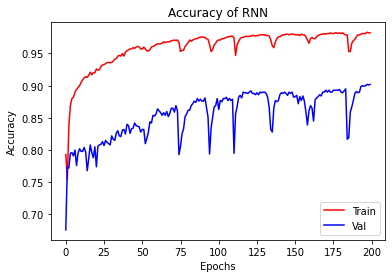

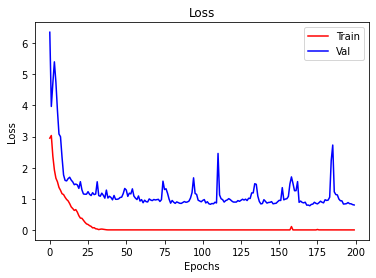

In [15]:
plt.plot(Results_acc.Epoch,Results_acc.Acc_train,'r',Results_acc.Epoch,Results_acc.Acc_val,'b')
plt.legend(['Train','Val'])
plt.title('Accuracy of RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_loss.Epoch,Results_loss.Loss_train,'r',Results_loss.Epoch,Results_loss.Loss_val,'b')
plt.legend(['Train','Val'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

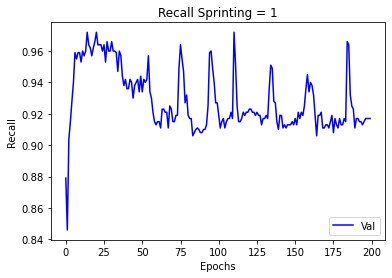

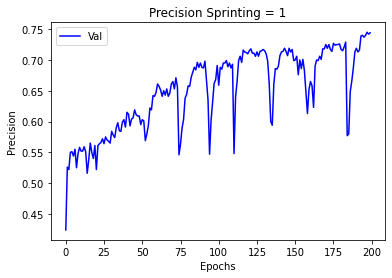

In [16]:
plt.plot(Results_recall.Epoch , Results_recall.Recall_val,'b')
plt.legend(['Val'])
plt.title('Recall Sprinting = 1')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_prec.Epoch,Results_prec.Prec_val,'b')
plt.legend(['Val'])
plt.title('Precision Sprinting = 1')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.show()

# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

In [17]:
classes = ['Not Sprinting', 'Sprinting']
y_pred = RNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

               precision    recall  f1-score   support

Not Sprinting       0.97      0.90      0.93      1624
    Sprinting       0.74      0.92      0.82       531

     accuracy                           0.90      2155
    macro avg       0.86      0.91      0.88      2155
 weighted avg       0.91      0.90      0.90      2155



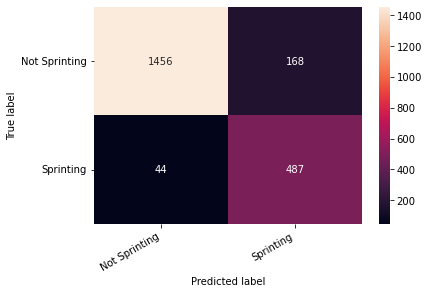

In [18]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Export results

In [19]:
df_results = pd.DataFrame(y_pred)
df_results.to_csv('Predictions_15x2_Quartor'+str(Quarter)+'_Overlap.csv')
df_results

,0
0,False
1,True
2,True
3,False
4,True
...,...
2150,False
2151,False
2152,False
2153,False


# Close Kernel

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>